<a href="https://colab.research.google.com/github/katearb/ipynb-projects/blob/master/w3_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from scipy import stats
import calendar
import scipy.stats as st

from IPython.display import set_matplotlib_formats
%matplotlib inline
plt.style.use('ggplot')

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.model_selection import KFold


import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv(r'https://raw.githubusercontent.com/katearb/files/main/AirQualityUCI_data.csv', sep=';', decimal=',')


## EDA
#### Step 1. General information about the dataset

From the description, we can figure out that all our features are continuous, except for date and time.

In [ ]:
len(data['Date'].unique())

391

In [ ]:
# explore data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


In [ ]:
# explore some statistics
data.describe()

CO(GT)  PT08.S1(CO)  ...           RH           AH
count  9357.000000  9357.000000  ...  9357.000000  9357.000000
mean    -34.207524  1048.990061  ...    39.485380    -6.837604
std      77.657170   329.832710  ...    51.216145    38.976670
min    -200.000000  -200.000000  ...  -200.000000  -200.000000
25%       0.600000   921.000000  ...    34.100000     0.692300
50%       1.500000  1053.000000  ...    48.600000     0.976800
75%       2.600000  1221.000000  ...    61.900000     1.296200
max      11.900000  2040.000000  ...    88.700000     2.231000

[8 rows x 13 columns]

Observations:
1. In each column there are missed values, that's why the metrics are shifted.
2. In the column NMHC, the majority of the values are suspected to be Nans.

In [ ]:
# explore nan values
data.replace(-200, np.nan).isnull().sum().sort_values(ascending=False)

NMHC(GT)         8443
CO(GT)           1683
NO2(GT)          1642
NOx(GT)          1639
AH                366
RH                366
T                 366
PT08.S5(O3)       366
PT08.S4(NO2)      366
PT08.S3(NOx)      366
PT08.S2(NMHC)     366
C6H6(GT)          366
PT08.S1(CO)       366
Time                0
Date                0
dtype: int64

In [ ]:
# explore the phenomenon of "366 nan values in each column"
data[data['AH'] == -200].head(10)

Date      Time  CO(GT)  ...      T     RH     AH
524  01.04.2004  14.00.00     1.7  ... -200.0 -200.0 -200.0
525  01.04.2004  15.00.00     1.9  ... -200.0 -200.0 -200.0
526  01.04.2004  16.00.00     2.3  ... -200.0 -200.0 -200.0
701  08.04.2004  23.00.00     2.0  ... -200.0 -200.0 -200.0
702  09.04.2004  00.00.00     2.4  ... -200.0 -200.0 -200.0
703  09.04.2004  01.00.00     1.8  ... -200.0 -200.0 -200.0
704  09.04.2004  02.00.00     1.0  ... -200.0 -200.0 -200.0
705  09.04.2004  03.00.00     1.0  ... -200.0 -200.0 -200.0
706  09.04.2004  04.00.00     1.0  ... -200.0 -200.0 -200.0
707  09.04.2004  05.00.00     0.9  ... -200.0 -200.0 -200.0

[10 rows x 15 columns]

In [ ]:
len(data[data['AH'] == -200])

366

In [ ]:
# explore nan values in Co, No2 and Nox
data[data['CO(GT)'] == -200][data['NO2(GT)'] == -200][data['NOx(GT)'] == -200].head()

Date      Time  CO(GT)  PT08.S1(CO)  ...  PT08.S5(O3)     T    RH      AH
39   12.03.2004  09.00.00  -200.0         1545  ...         1588   9.2  56.2  0.6561
568  03.04.2004  10.00.00  -200.0         1418  ...         1410  19.7  43.3  0.9837
569  03.04.2004  11.00.00  -200.0         1410  ...         1372  20.7  41.7  1.0092
570  03.04.2004  12.00.00  -200.0         1438  ...         1266  23.3  35.8  1.0098
571  03.04.2004  13.00.00  -200.0         1278  ...         1014  23.8  30.5  0.8897

[5 rows x 15 columns]

In [ ]:
len(data[data['CO(GT)'] == -200][data['NO2(GT)'] == -200][data['NOx(GT)'] == -200])

1226

#### Assuptions:
1. NMHC(GT) has 90% nan values. As a result, the most sensible way to deal with this column is removal.
2. There are some samples where the majority of features are missed. If we try to fill them up with some statistics, this can lead to a distortion of the real situation, because most of theit features won't be 100% truth. Suggestion: as there are not so many of them (only 366 observations, which is near 4% of the total), I came up with deleting these rows.
3. As there are pretty many Nans in Co, No2 and Nox, some advanced tools will be applied for filling them up in Data Preparation section.


### Step 2. Univariate analysis

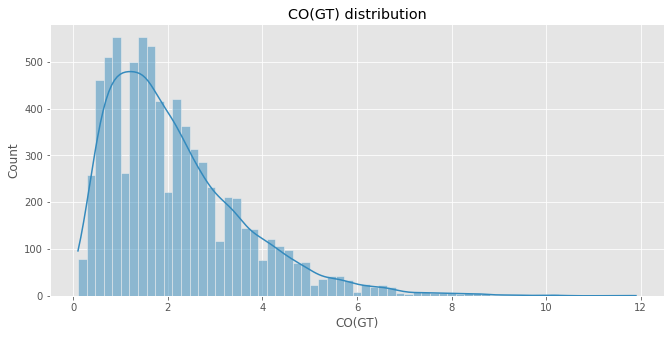

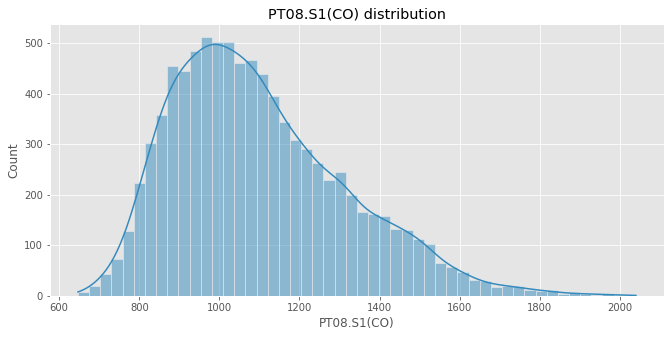

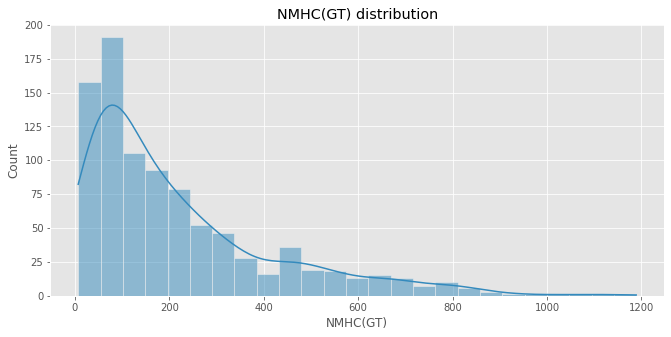

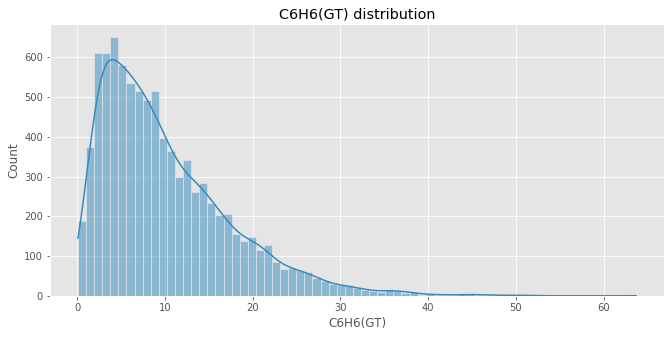

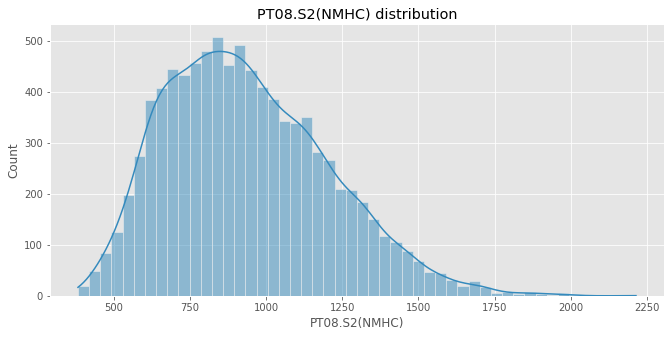

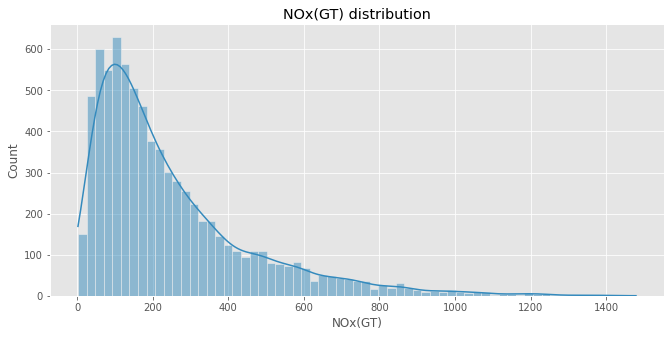

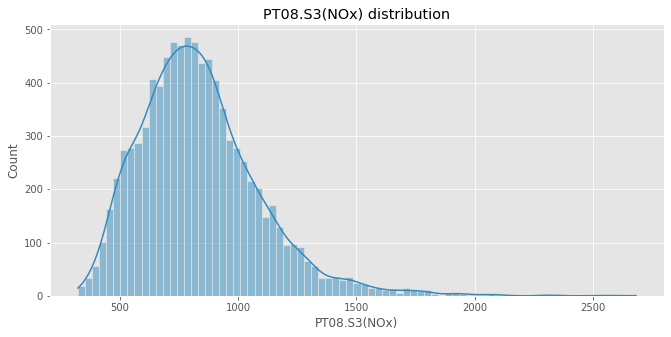

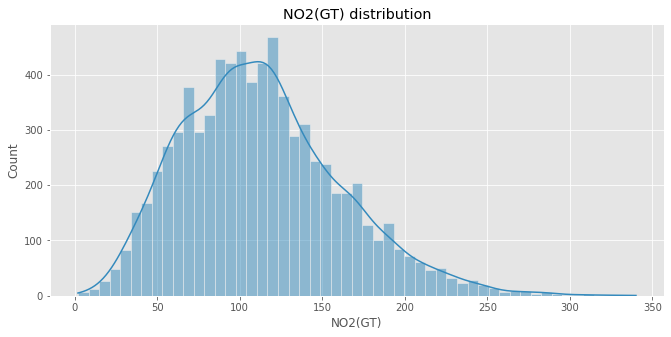

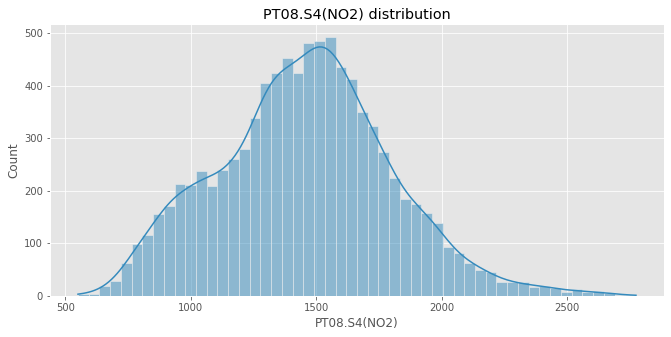

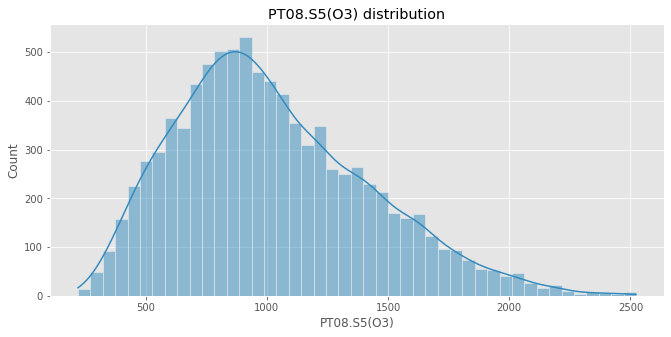

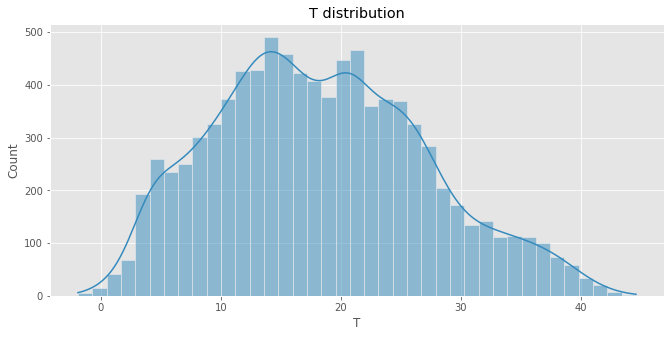

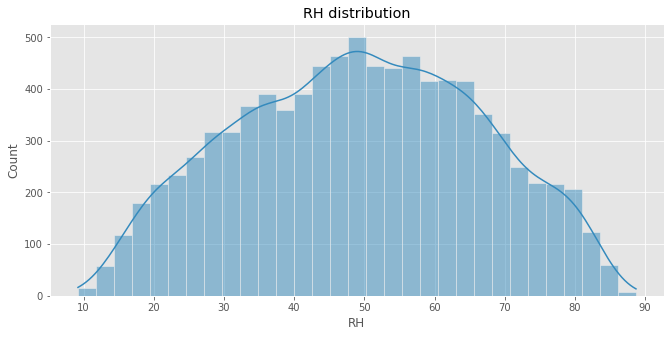

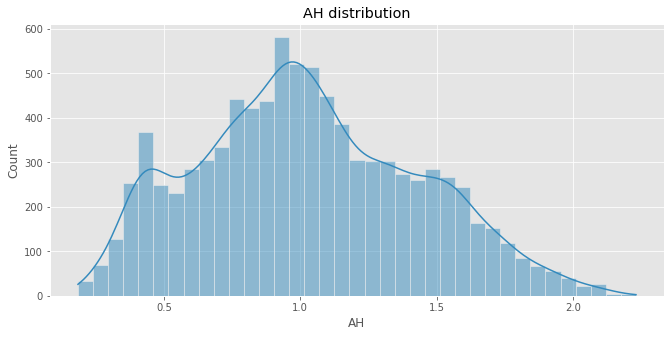

In [ ]:
# explore feature distribution excluding nan-values
for column in data.select_dtypes(exclude=np.object):
  data_hist = data.loc[data[column] != -200][column]
  plt.figure(figsize=(11, 5))
  sns.histplot(data_hist, kde=True)
  plt.title(f'{column} distribution')
  plt.show()

#### Observations:
1. Many of the features (all of them that represent chemical content values) are greatly positive skewed (outliers in high values can be detected).
2. All the features derivate from normal distribution, but still they have one mode (except temperature and absolute humidity: they have two)

In [ ]:
data_no_na = pd.read_csv(r'https://raw.githubusercontent.com/katearb/files/main/AirQualityUCI_data.csv', sep=';', decimal=',', na_values=-200).dropna()

In [ ]:
def draw_boxplot(data: pd.DataFrame,
                 column: str,
                 color: str='pink',
                 title: str=''):
    plt.figure(figsize=(10, 2), dpi=80)
    sns.boxplot(data=data[column], orient='h', color=color)
    plt.title(title)
    plt.xlabel('value')
    plt.show()

    return

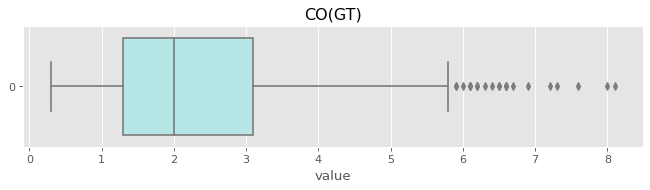

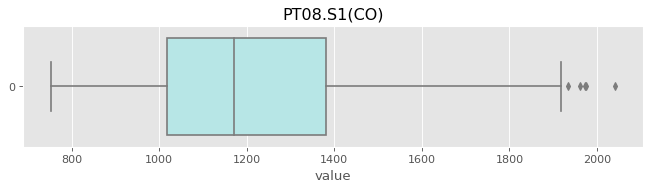

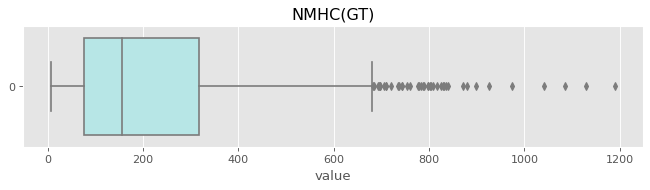

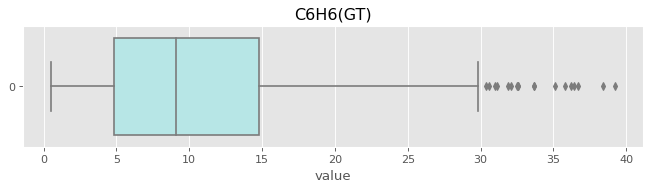

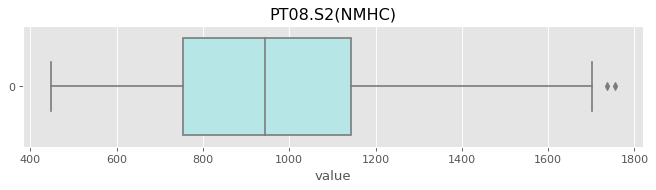

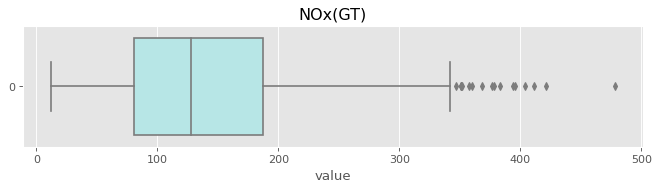

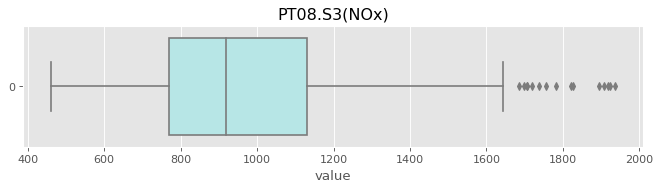

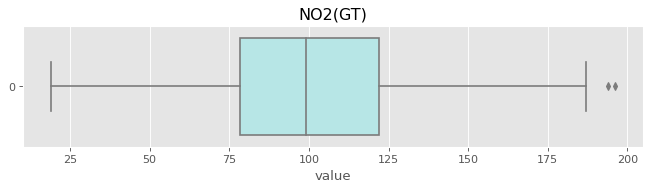

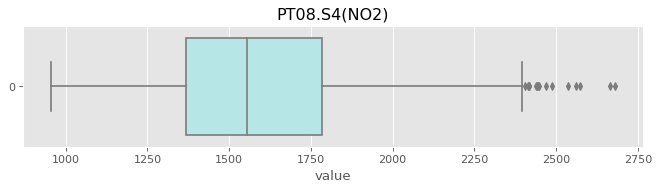

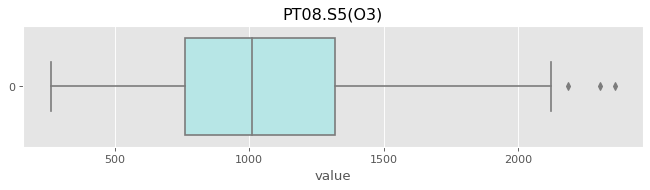

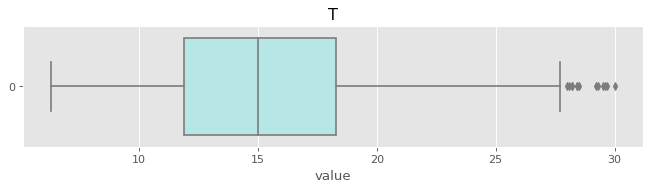

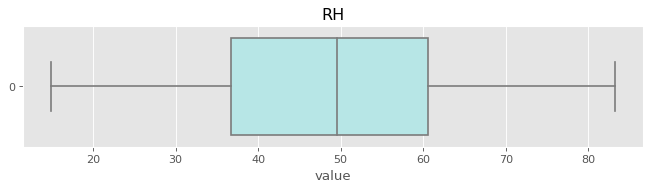

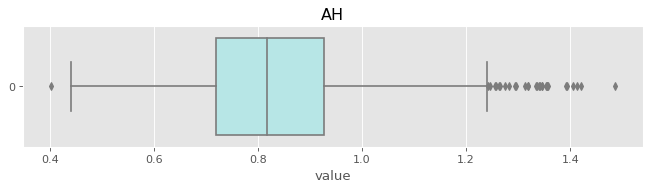

In [ ]:
# boxplot: vusualize outliers
for column in data_no_na.select_dtypes(exclude=np.object):
    draw_boxplot(data_no_na, column, 'paleturquoise', column)

### Step 3. Multivariate analysis

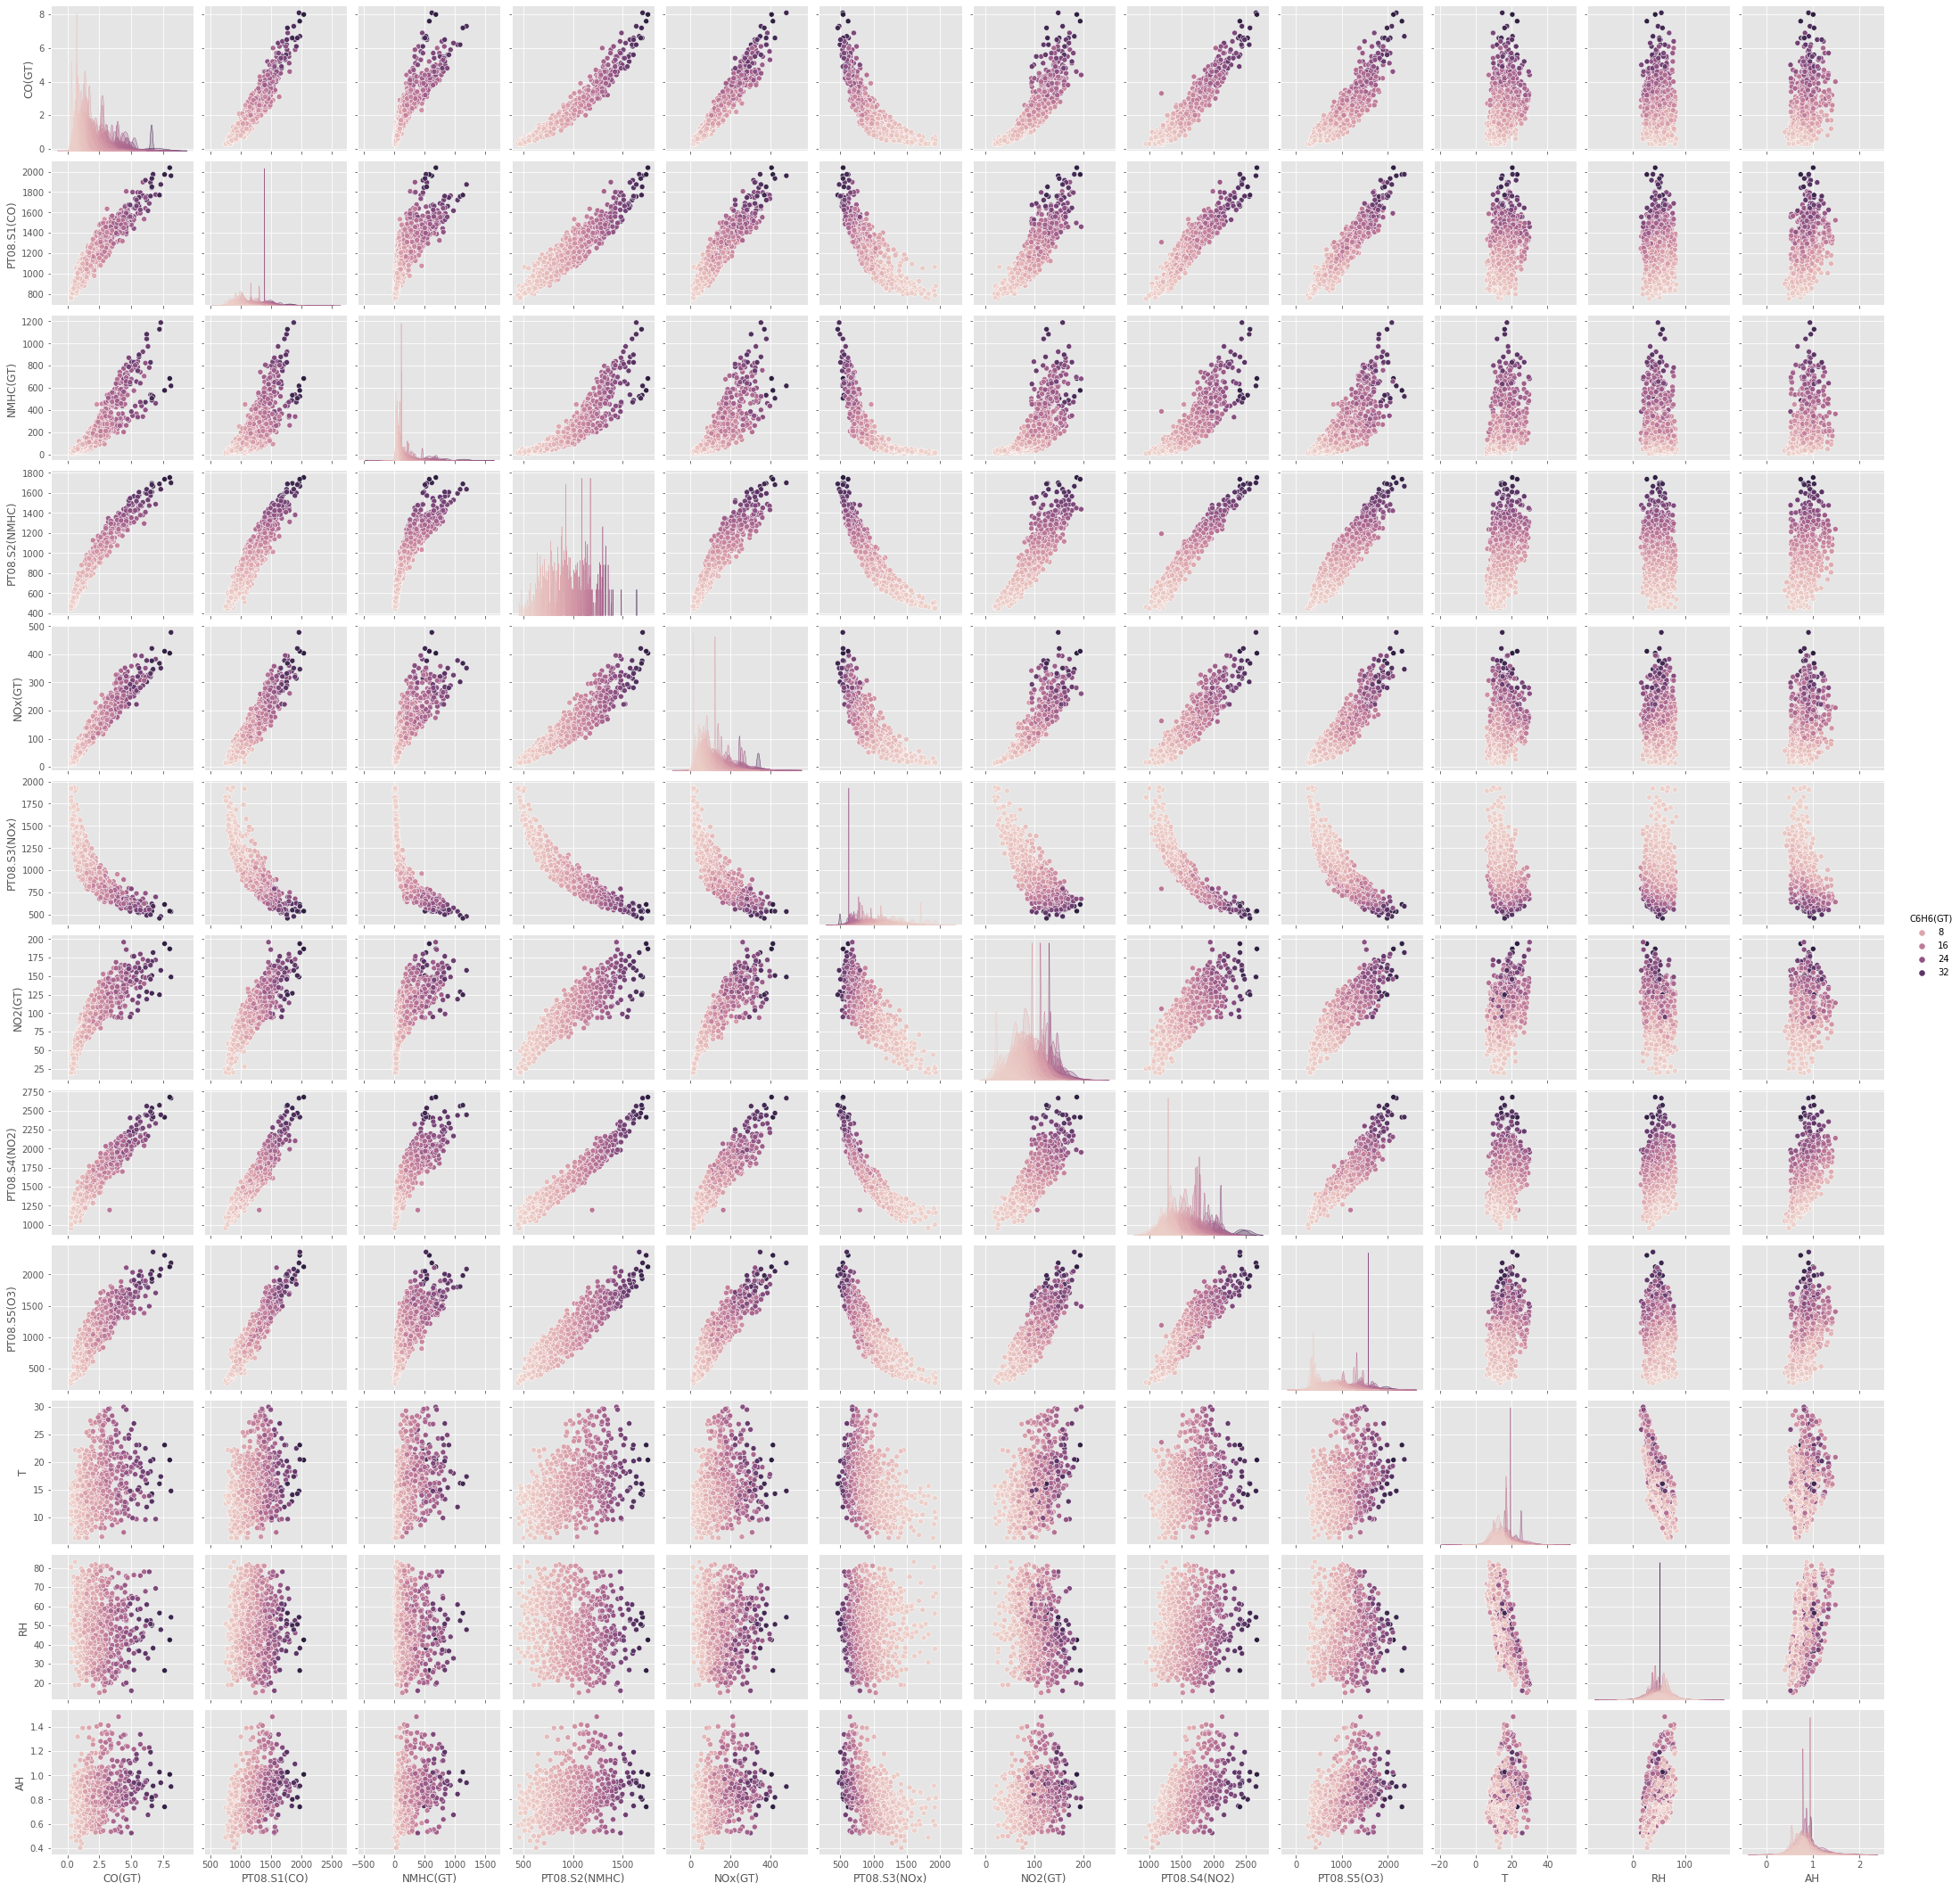

In [ ]:
#explore pair relations depending on the target
sns.pairplot(data_no_na, hue='C6H6(GT)')
plt.show()

#### Observations:
1. All chemical features are positive correlated with each other. The exeption is PT08.S3(Nox). The correlation between this feature and others is negative.
2.There is no correlation between chemical features and surrounding conditions.
3. There is correlation between all the features and the target.

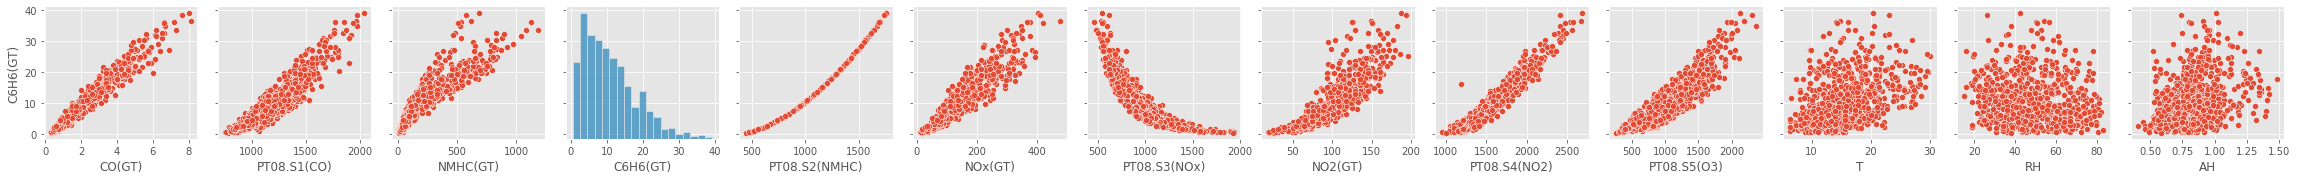

In [ ]:
# explore pair relations with the target
sns.pairplot(data_no_na, y_vars={'C6H6(GT)'})
plt.show()

The strongest correlation is observed between the target and PT08.S2, but still correlations with other chemical features is very strong.

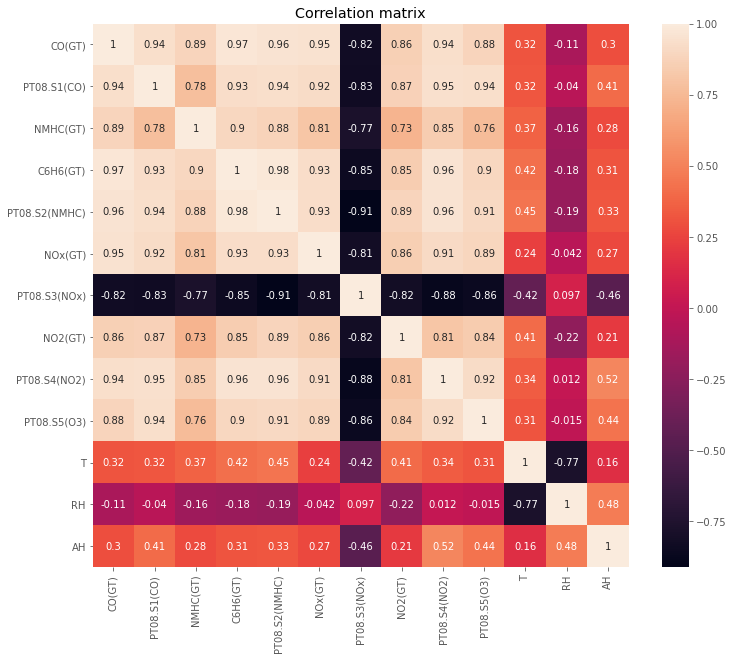

In [ ]:
# correlation matrix
data_corr = data_no_na.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(data_corr, annot=True)
plt.title('Correlation matrix')
plt.show()

#### Observations:
1. All chemical features are positive correlated to each other.An exception is PT08.S3. Its correlation with others is negative.
2.There is some positive (negative for PT08.S3) correlation between temperature and chemicals features, but it is not so strong.
3. The least correlated feature is relative humidity. Its strongest correlation is with temperature.
4. Traget: it is correlated to chemical features with almost 1 coefficient. Some correlation with temperature and absolute humidity is observed. There is no correlation to relative humidity.

Obviously, multicolinearity is a huuuuge problem in this dataset. There are some possible ways to deal with it:
1. We can use dimensional reduction.
2. We can use regularization, e.g. lasso which will turn down some features to zero.

#### Data and Time features
There are two object-features^ date and time. We cannot use it in our modelor even explore it properly.
I considered to find out whether there is some correlation between the target or given features and data/time. I suggested to alter date feaure into numeric one by transforming it to Datetime-type first, and then change it to ordinal to be able to build a correlation matrix to see whether this feature is any usefull.

In [ ]:
def create_new_features(df: pd.DataFrame):

  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
  df['Date'] = df['Date'].map(dt.datetime.toordinal)

  df['Hour'] = df['Time'].apply(lambda x: int(x.split('.')[0]))
  df.drop('Time', axis=1, inplace=True)

  return

In [ ]:
create_new_features(data)
create_new_features(data_no_na)

In [ ]:
data_corr_new = data_no_na.corr()

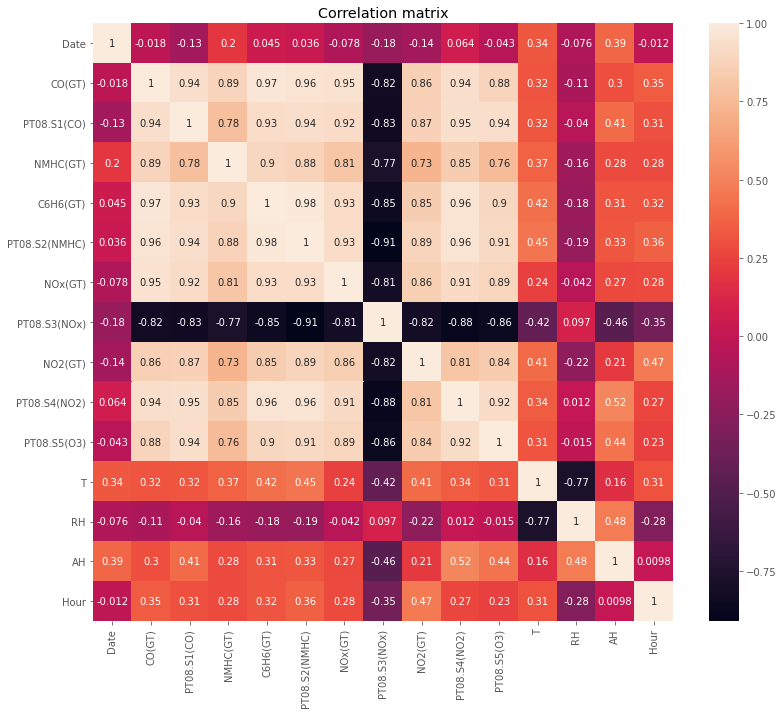

In [ ]:
plt.figure(figsize=(13, 11))
sns.heatmap(data_corr_new, annot=True)
plt.title('Correlation matrix')
plt.show()

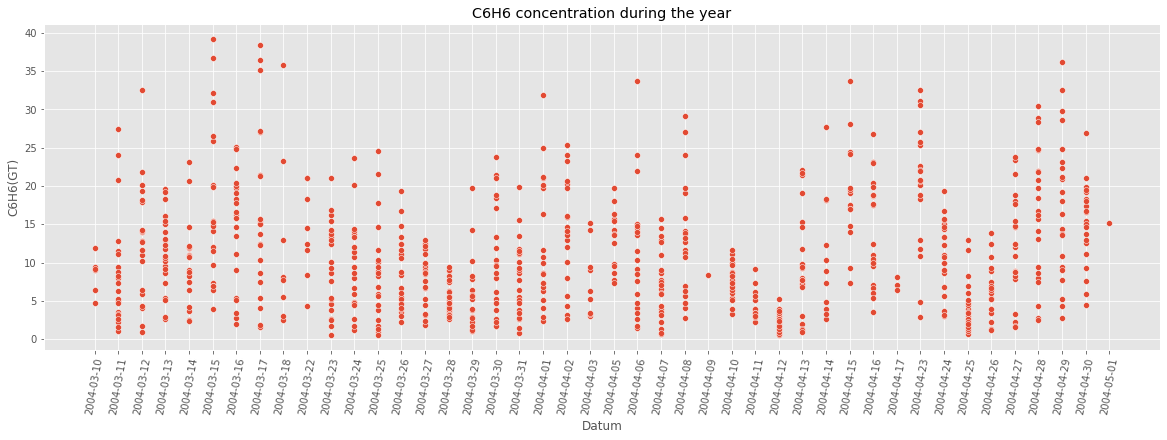

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot([str(dt.date.fromordinal(x)) for x in data_no_na['Date']], data_no_na['C6H6(GT)'])
plt.xticks(rotation=80)
plt.title('C6H6 concentration during the year')
plt.xlabel('Datum')
plt.show()

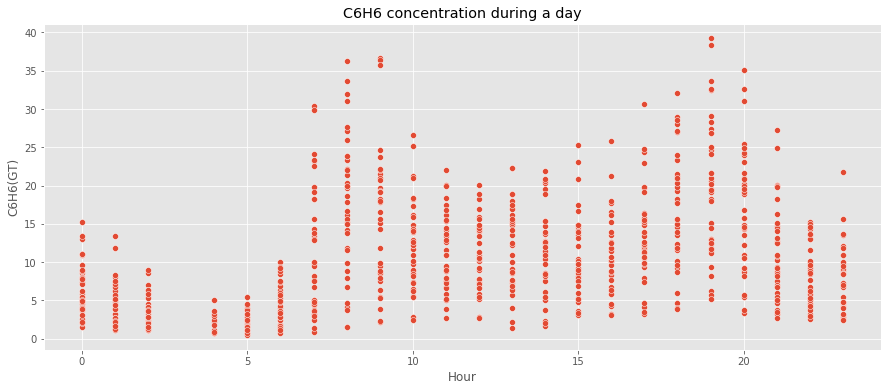

In [ ]:
plt.figure(figsize=(15, 6))
sns.scatterplot(data_no_na['Hour'], data_no_na['C6H6(GT)'])
plt.title('C6H6 concentration during a day')
plt.show()

There is no correlation between target and Date, but there is some with hour-feature. New features correlate also to some other except target.

On the scatter plot, we can see some tendencies depending on Hour feature -- it shows the relations between city's activity and emissions in the air: the concentration of C6H6 falls after 9pm and reaches the lowest level at 4-5am (at the night activity of the cuty and factories is the lowest). Then it is rising till 9am(when all people drive to their work). After that, it falls again till the lunch and increases till 7pm (when people's activity on the streets is high: they go home after work, go for a work, etc.). During the day, the concentration is still pretty high (higher than at night) because factories and manufactories are working.

On the scatter plot for the whole year, I can't really see any reasonable dependencies, but hour-feature prompted me to think about the dependence of the concentration of the substance depending on the activity of people in the city. Accordingly, this may be due to the fact that it is a weekday or a weekend in a particular sample.
I an going to create a new feature -- "weekday"/

In [ ]:
def create_weekday(df: pd. DataFrame):
  days = [dt.date.fromordinal(x) for x in df['Date']]
  wdays = {dt.datetime.toordinal(day): day.weekday() for day in days}
  df['Weekday'] = [wdays[day] for day in df['Date']]

  return

In [ ]:
create_weekday(data)
create_weekday(data_no_na)

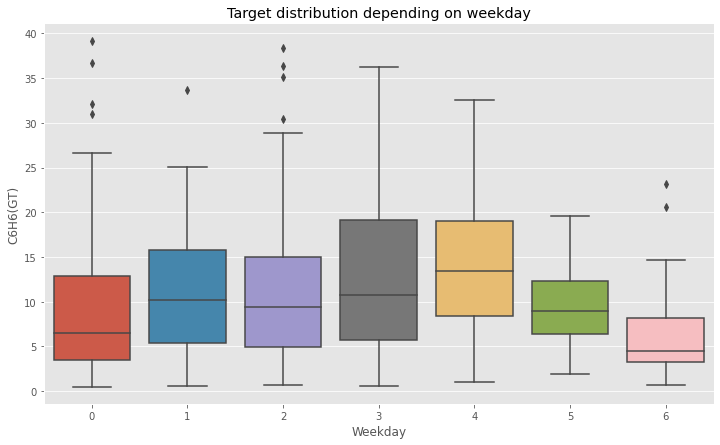

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x=data_no_na['Weekday'], y=data_no_na['C6H6(GT)'])
plt.title('Target distribution depending on weekday')
plt.show()

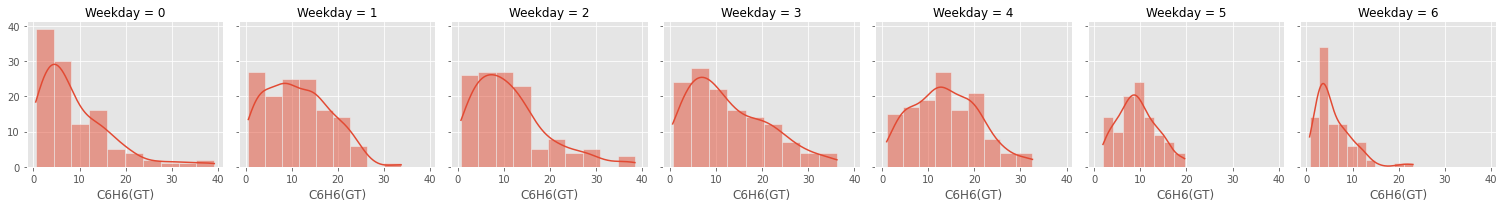

In [ ]:
g = sns.FacetGrid(data_no_na,  col="Weekday")
g.map(sns.histplot, "C6H6(GT)", kde=True)
plt.show()

To check, whether there is differences in target distribution dependent on weekday, I am going to use Kruskal-Wallis H Test, as the groups number is > 2 and they are not normal distributed.

In [ ]:
# Kruskal-Wallis H Test for 7 groups
mon = data[data['Weekday'] == 0]['C6H6(GT)']
tue = data[data['Weekday'] == 1]['C6H6(GT)']
wed = data[data['Weekday'] == 2]['C6H6(GT)']
thu = data[data['Weekday'] == 3]['C6H6(GT)']
fri = data[data['Weekday'] == 4]['C6H6(GT)']
sat = data[data['Weekday'] == 5]['C6H6(GT)']
sun = data[data['Weekday'] == 6]['C6H6(GT)']

stat, p = st.kruskal(mon, tue, wed, thu, fri, sat, sun)
print(f'stat={stat}, p={p}')
if p > 0.05:
	print('The same distribution')
else:
	print('Different distributions')

stat=467.6150182370812, p=7.92667051674069e-98
Different distributions


Not surprisingly, the distributions from day to day are different. Based on this results, I am going to keep this feature and delete "Date" later. "Hour" feature will be kept as well.

## Data preparation

In [ ]:
def draw_target_hist(target: pd.core.series.Series,
                     title: str='Distribution of y'):
  plt.figure(figsize=(10, 5))
  sns.histplot(target, kde=True)
  plt.title(title)
  plt.show()  

  return

In [ ]:
def draw_residuals(X_val: pd.DataFrame,
                   y_val: pd.core.series.Series,
                   linreg):
    pred = linreg.predict(X_val)
    errors = y_val - pred

    plt.figure(figsize=(8, 5))
    plt.scatter(list(range(len(errors))),errors)
    plt.title("Distibution of errors")
    plt.ylabel('Error')
    plt.xlabel('Index')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.scatter(pred,errors)
    plt.title('Relationship of true value vs error (residual analysis)')
    plt.ylabel('Error')
    plt.xlabel('True value')
    plt.show()

    return

In [ ]:
def evaluate_model(X_train: pd.DataFrame,
                   X_val: pd.DataFrame,
                   y_train: pd.core.series.Series,
                   y_val: pd.core.series.Series,
                   pipeline):

    kf = KFold(n_splits=5)
    X_train.index = y_train.index = [i for i in range(len(X_train))]

    for train_index, _ in kf.split(X_train):
        X_train_kf = X_train[X_train.index.isin(train_index)]
        y_train_kf = y_train[y_train.index.isin(train_index)]

        pipeline.fit(X_train_kf, y_train_kf)

    draw_residuals(X_val, y_val, pipeline)

    pred_val = pipeline.predict(X_val)
    pred_train = pipeline.predict(X_train)

    return pd.DataFrame({
    'train_RMSE': [rmse(y_train, pred_train), baseline_train_rmse], 
    'train_R2': [r2_score(y_train, pred_train), baseline_train_r2],
    'val_RMSE': [rmse(y_val, pred_val), baseline_val_rmse],
    'val_R2': [r2_score(y_val, pred_val), baseline_val_r2],
    }, index=['Model', 'Baseline'])


In [ ]:
# drop rows with many missing features (based on EDA)
def remove_missing(df: pd.DataFrame):
  return df[df['AH'] != -200]

In [ ]:
# drop NMHC(GT) column because of 90% missing values (based on EDA)
data_to_split = remove_missing(data)
X = data_to_split.drop(['NMHC(GT)', 'Date', 'C6H6(GT)'], axis=1)
y = data_to_split['C6H6(GT)']

In [ ]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, 
                                                    shuffle=True, test_size=0.3)


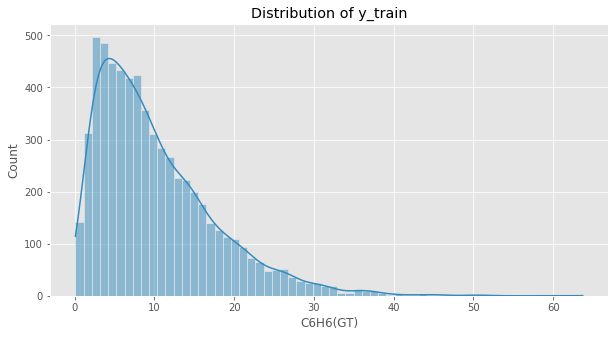

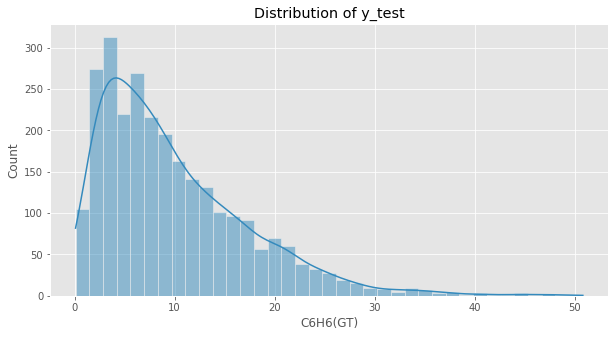

In [ ]:
draw_target_hist(y_train[y_train != -200], 'Distribution of y_train')
draw_target_hist(y_test[y_test != -200], 'Distribution of y_test')

The distributions of train and test target seem to be nearly the same, but we can see that the tail of train distribution is a bit long than test's tail: train crosses 60, while test ends near 50. Perhabs, there are so few samples with such values (maybe only ~1), so they couldn't get into both distributions.

In [ ]:
log_transform = FunctionTransformer(np.log1p)

In [ ]:
pipeline = Pipeline([
    ('impute', KNNImputer(missing_values=-200, n_neighbors=3)),
    ('scale', MinMaxScaler()),
    ('transform', log_transform) # based on EDA as the features are not normal distributed
])

full_pipeline = Pipeline([
      ('transform', pipeline),
      ('estimator', LinearRegression())
 ])

Two metrics will be used to evaluate models: one relative and one absolute:

* RMSE - absolute metric: easy to perform gradient descend (compared to MAE which is not differentiable in zero), easier to interpret (compared to mse), number of outliers is not huge (and in some cases I going to remove them), units of the targets are not large (from 0 to ~40).

* R2 -- relative metric(is independent of the data units of measurement), easy to interpret, helps us to understand whether our model is any good.

In [ ]:
def rmse(y: pd.core.series.Series,
         Y_pred: np.ndarray):
    return np.sqrt(mse(y, Y_pred))

I am going to perform linear model in different conditions:
1. without outliers
2. logged target 
3. keep only high-correlated features (i.e. keep only a few features)
4. with dimentsion reduction
5. reduce multicolinearity using regularization (lasso, ridge)

All the results after these chages I am going to compare with a baseline -- linear model learning on the dataset "per se": wihout outliers removal, no logged target and with multicolinearity.

And check whether these changes affect the model dramatically.


## Baseline

In [ ]:
# LR with outliers, no logged target, with correlated features

X_train_tr, X_val_tr, y_train_tr, y_val_tr = train_test_split(X_train, 
                                                              y_train, 
                                                              random_state=0, 
                                                              shuffle=True, 
                                                              test_size=0.3)

X_train_tr = pd.DataFrame(pipeline.fit_transform(X_train_tr, y_train_tr), 
                                    columns=X_train_tr.columns)

X_val_tr = pd.DataFrame(pipeline.fit_transform(X_val_tr, y_val_tr), 
                                        columns=X_train_tr.columns)
linear_model = LinearRegression()
linear_model.fit(X_train_tr, y_train_tr)

baseline_train_r2 = linear_model.score(X_train_tr, y_train_tr)
baseline_train_rmse = rmse(y_train_tr, linear_model.predict(X_train_tr))
baseline_val_r2 = linear_model.score(X_val_tr, y_val_tr)
baseline_val_rmse = rmse(y_val_tr, linear_model.predict(X_val_tr))

print(f'R2 Score: train = {baseline_train_r2}, val = {baseline_val_r2}')
print(f'RMSE Score: train = {baseline_train_rmse}, val = {baseline_val_rmse}')

R2 Score: train = 0.9593745862424883, val = 0.926517463730443
RMSE Score: train = 1.4954498096285223, val = 2.0356596626560073


R2 score looks good (is very close to 1) and shows even better result on the validation, than on the training. 
RMSE score looks much sadder than r2: it is in 1.5 times worse on validation than on training (1.47 and 2.02 respectively).

We will compare these scores to others models implemented after some changes in the data.

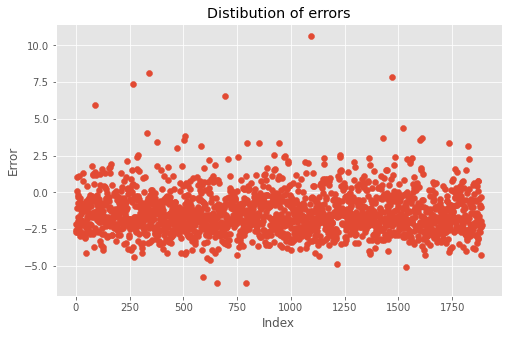

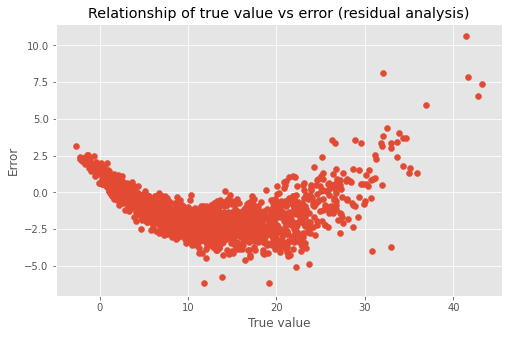

In [ ]:
#residual analysis
draw_residuals(X_val_tr, y_val_tr, linear_model)

Well... The plots don't look well.

On the first plot, we see some extreme values in errors. This can be a sign of outliers in the data.

There is some quadratic pattern in residuals on the second scatter plot.This plot exhibits heteroscedasticity as well.  It seems that linear model doesn't fit our data well. Just like in the first graph, there are outliers here.

## 1. Learning without outliers

In [ ]:
# remove outliers with Z-score
def remove_outliers(df: pd.DataFrame,
                    y: pd.core.series.Series,
                    threshold: int=3):
  new_df = df.copy()
  new_y = y.copy()

  for column in new_df.columns:
    z = np.abs(stats.zscore(new_df[column]))
    new_df = new_df[(z<3)]
    new_y = new_y[new_df.index]

  z = np.abs(stats.zscore(new_y))
  new_y = new_y[(z < 3)]
  new_df = new_df.loc[new_y.index, :]

  return new_df, new_y

In [ ]:
#delete outliers
X_no_outliers, y_no_outliers = remove_outliers(X, y)

#split into train-test
X_train_no_outlrs, X_test_no_outlrs, y_train_no_outlrs, y_test_no_outlrs = train_test_split(
                                                                                X_no_outliers, y_no_outliers, 
                                                                                random_state=0, shuffle=True,
                                                                                test_size=0.3)

In [ ]:
# transform train
X_no_outliers = pd.DataFrame(pipeline.fit_transform(X_train_no_outlrs, 
                                                    y_train_no_outlrs), 
                                                    columns=X_train.columns)


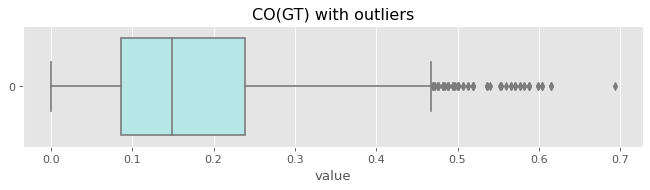

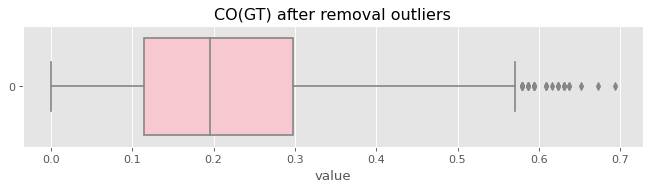

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


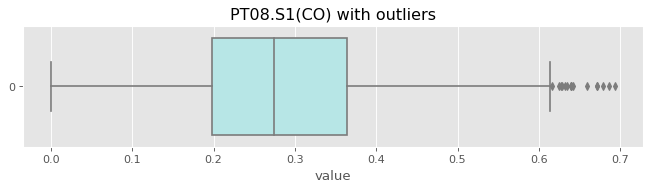

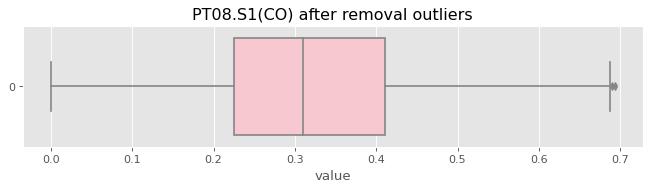

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


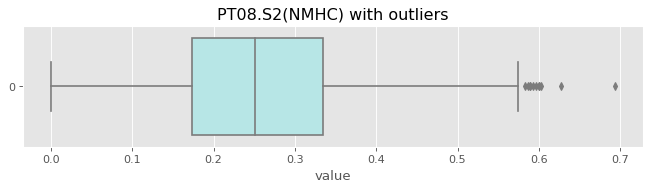

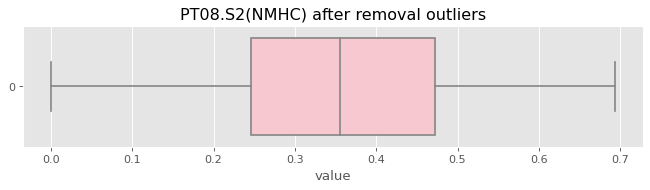

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


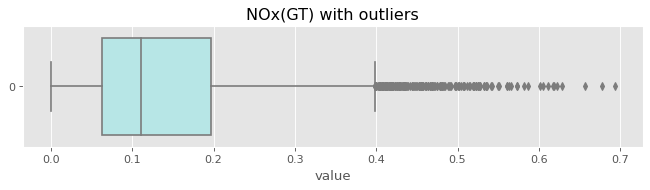

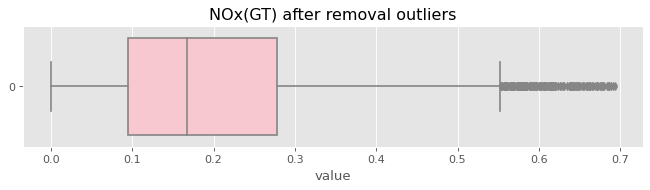

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


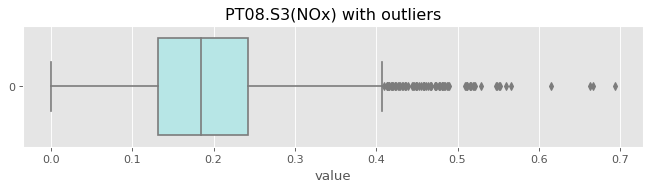

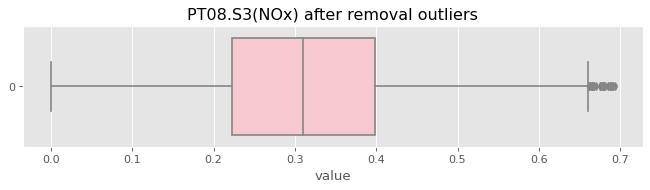

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


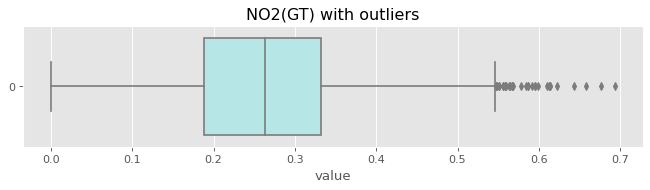

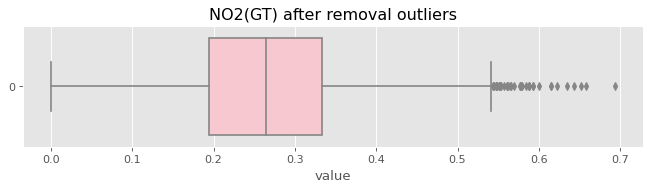

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


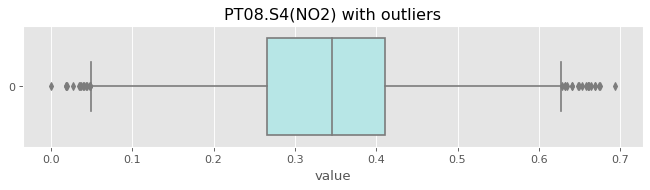

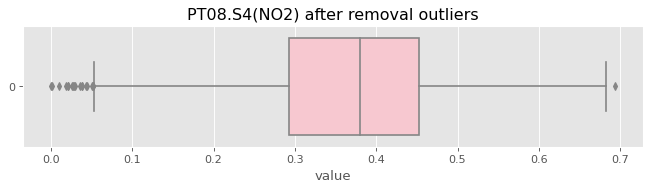

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


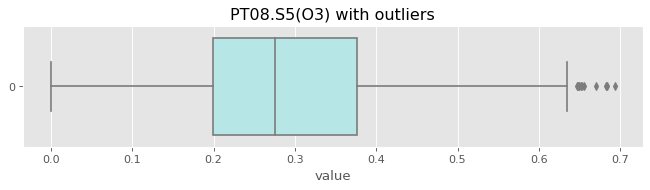

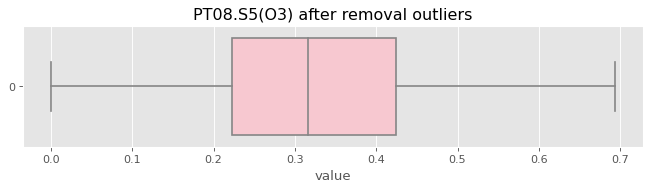

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


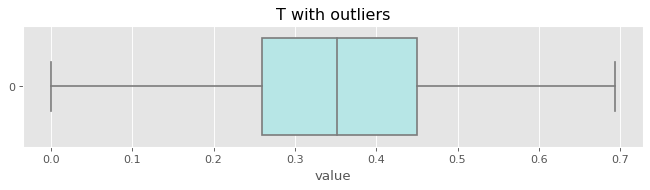

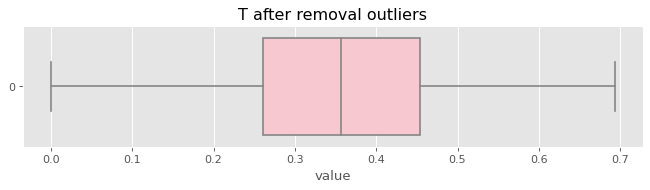

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


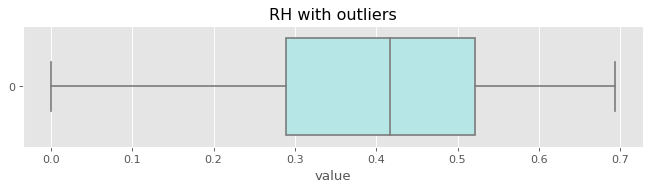

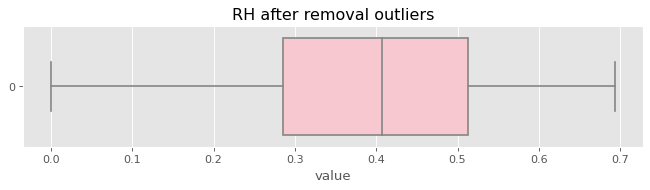

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


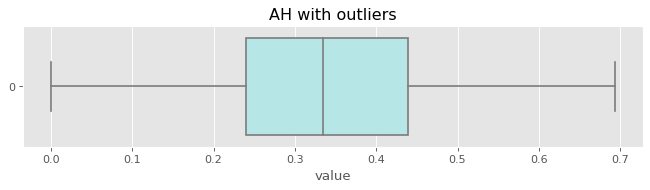

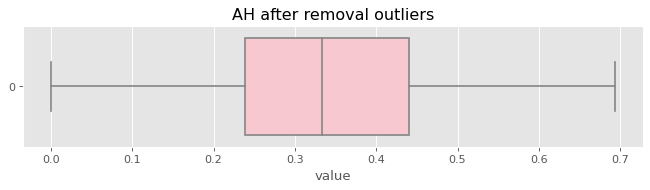

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


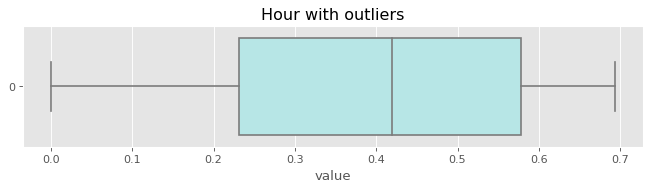

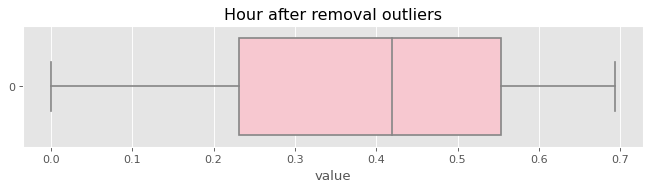

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


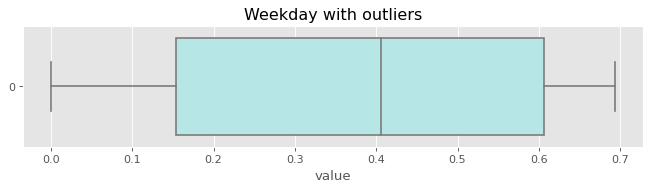

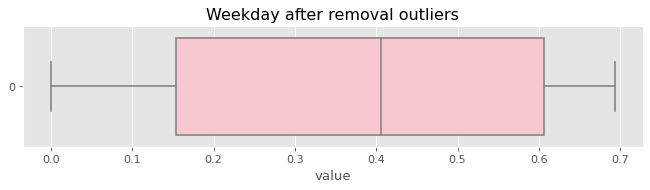

=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-==-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-=


In [ ]:
# observe outliers after transformation
for column in X_train_tr.columns:
    draw_boxplot(X_train_tr, column, 'paleturquoise', 
                 f'{column} with outliers')
    draw_boxplot(X_no_outliers, column, 'pink', 
                 f'{column} after removal outliers')
    print('=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-==-=-=-=-='*2)

Althought, there are still some outliers, but their number is now smaller.

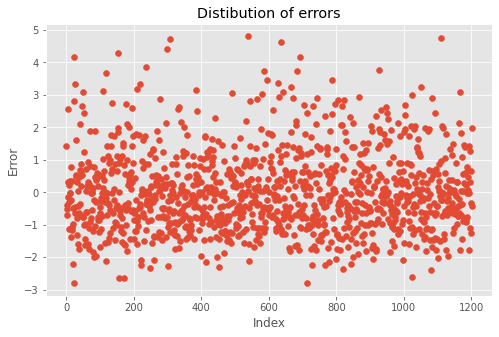

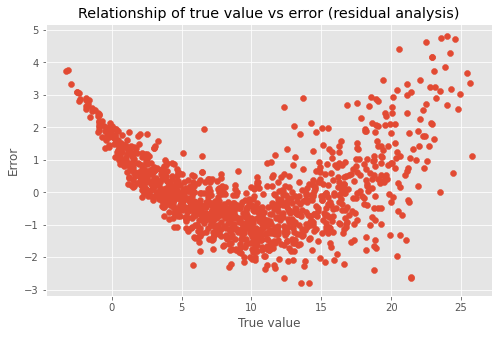

train_RMSE  train_R2  val_RMSE    val_R2
Model       1.203311  0.963186   1.23087  0.962194
Baseline    1.495450  0.959375   2.03566  0.926517

In [ ]:
#split into train-validation
X_train_no_outlrs, X_val_no_outlrs, y_train_no_outlrs, y_val_no_outlrs = train_test_split(
                                                                            X_train_no_outlrs, 
                                                                            y_train_no_outlrs, 
                                                                            random_state=0, 
                                                                            shuffle=True,
                                                                            test_size=0.2)
no_outlrs_pipeline = clone(full_pipeline)
evaluate_model(X_train_no_outlrs, X_val_no_outlrs, y_train_no_outlrs, y_val_no_outlrs,
               no_outlrs_pipeline)


These plots look similar to the previous ones.

On the first plot, we see some extreme values in errors.

There is also quadratic pattern in residuals on the second scatter plot, and it's even more vivid, compared to the baseline.This plot exhibits heteroscedasticity as well. Just like on the first graph, there are outliers here.

RMSE score is smaller here than on the baseline. The difference between train and validation is not so dramatic as on the base line, but still validation score is a bit worse.

R2 score of the baseline and the model are almost identic on the train. However, for the model it stays remain on the validation, while it is getting worse on the baseline. To conclude, the model is not so overfitted as the baseline.

* Model with removed outliers works better than baseline.

## 2. Learning with Log target

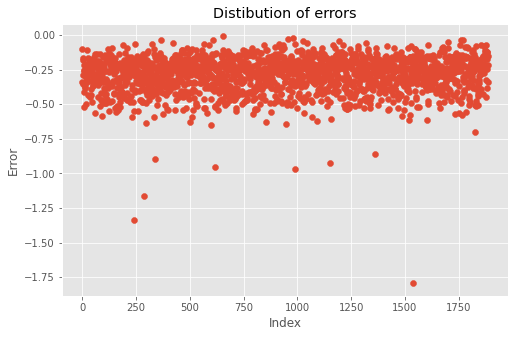

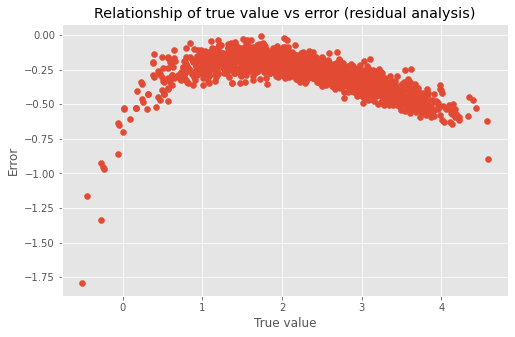

train_RMSE  train_R2  val_RMSE    val_R2
Model       0.112858  0.981809  0.315134  0.850642
Baseline    1.495450  0.959375  2.035660  0.926517

In [ ]:
# evaluate using logged target
y_train_log, y_val_log = pd.Series(np.log(y_train_tr)), pd.Series(np.log(y_val_tr))
log_pipeline = clone(full_pipeline)
evaluate_model(X_train_tr, X_val_tr, y_train_log, y_val_log, log_pipeline)

These scatters look more interesting and more different from the baseline compared to the previous one.

Now, we see outliers which are lower than the majority.

The residual pattern is also different. There is also quadratic pattern, but now it is with "minus".This plot doesn't  exhibit heteroscedasticity. Just like on the first graph, there are outliers here.

RMSE comparison is not relevant now, as the target scale is different due to the logarithm.

The model shows the better R2 result on train, but it is getting much worse on the validation --> the model is overfitted.

* Model with logged target works worse than baseline.

## 3. Learning with a few high correlated features

In [ ]:
def keep_high_correlated(X, y):
  new_X = X.copy()
  new_X['target'] = y
  X_corr = new_X.corr()
  condition = np.abs(X_corr.target) > 0.7
  top_corr = X_corr.loc[condition, condition].columns

  return new_X[top_corr]

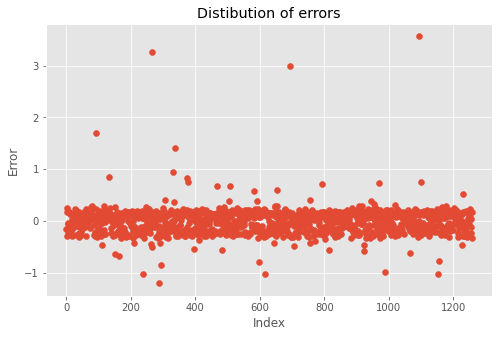

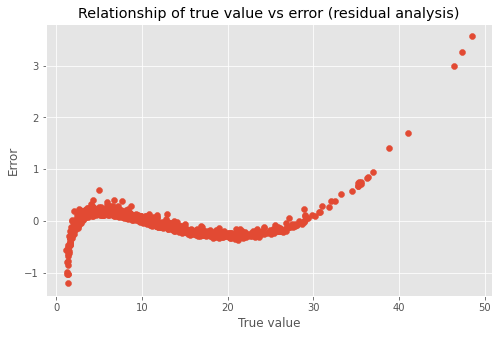

train_RMSE  train_R2  val_RMSE    val_R2
Model       0.252395  0.998838  0.266582  0.998772
Baseline    1.495450  0.959375  2.035660  0.926517

In [ ]:
# evaluate keeping most correlated feature

X_train_corr = keep_high_correlated(X_train, y_train)
X_train_corr, X_val_corr, y_train_corr, y_val_corr = train_test_split(X_train_corr, 
                                                              y_train, random_state=0, 
                                                              shuffle=True, test_size=0.2)
corr_pipeline = clone(full_pipeline)
evaluate_model(X_train_corr, X_val_corr, y_train_corr, y_val_corr, corr_pipeline)

Now, some outliers are above and some are under the majority.

The residual pattern is different again. The scatter plot has cubic pattern and doesn't exhibit heteroscedasticity. There are outliers here in the right top corner.

RMSE is 7 times smaller than on the baseline. Good result! On the validation is growth a bit, but it look ok.

R2 score looks fantastic and almost equals to 1. Moreover, it hasn't changed on the validation.

It is not a surprise that this model works so well as the correlation between the target and the features is so high that it almost equal to 1 in some cases.

* Model with only high correlated features works way better than baseline.

## 4. Dimension reduction
PCA will be used because our data is high-correlated and not sparse.

In [ ]:
pca = PCA(n_components=0.99)
data_to_transform = pd.DataFrame(pipeline.fit_transform(X_train), 
                                    columns=X_train.columns)
X_train_pca = pca.fit_transform(data_to_transform)

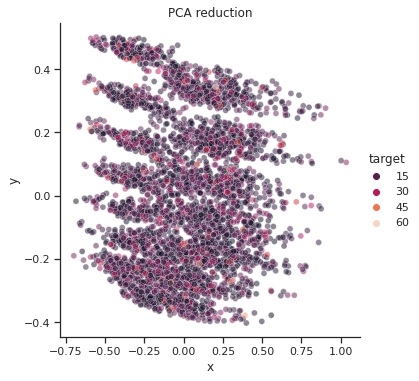

In [ ]:
plot_df = pd.DataFrame.from_records(data=X_train_pca[:,:2],columns=["x","y"])
plot_df['target'] = y_train

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='rocket', alpha=0.5)
plt.title('PCA reduction')
plt.show()

In [ ]:
len(pca.explained_variance_ratio_)

9

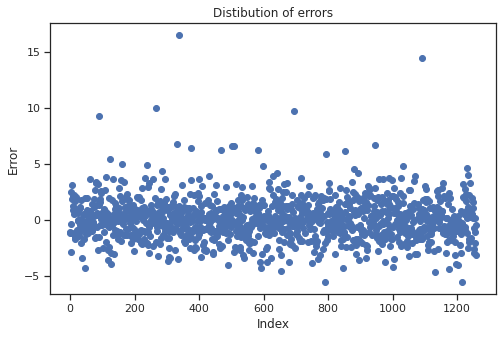

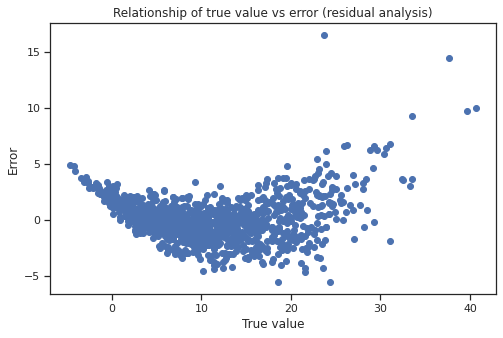

train_RMSE  train_R2  val_RMSE    val_R2
Model        1.93234  0.931905   1.87480  0.939246
Baseline     1.49545  0.959375   2.03566  0.926517

In [ ]:
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_pca, 
                                                                  y_train, 
                                                                  random_state=0, 
                                                                  shuffle=True,
                                                                  test_size=0.2)

pca_pipeline = clone(full_pipeline)
pca_pipeline.fit(X_train_pca, y_train_pca)

draw_residuals(X_val_pca, y_val_pca, pca_pipeline)

pred_val = pca_pipeline.predict(X_val_pca)
pred_train = pca_pipeline.predict(X_train_pca)

pd.DataFrame({
'train_RMSE': [rmse(y_train_pca, pred_train), baseline_train_rmse], 
'train_R2': [r2_score(y_train_pca, pred_train), baseline_train_r2],
'val_RMSE': [rmse(y_val_pca, pred_val), baseline_val_rmse],
'val_R2': [r2_score(y_val_pca, pred_val), baseline_val_r2],
}, index=['Model', 'Baseline'])

Outliers stayed with us.

The residuals show quadratic pattern, but now it is not so vivd.This plot exhibit heteroscedasticity higher than any other plot before.

RMSE is worse on the train for the model than for the baseline, but it stays remain on validation. 

The model shows a bit worse R2 result on train, but it is also stable.

Model with logged target works worse than baseline, but more sustainable.

### Conclusion to all observations:
* Residual analysis shows that linear model describes our data not great --> it makes sense to try polynomial regression (it is in the end of the notebook).
* But still, as there many high correlated features, linear models perform not bad R2-scores.
* Some techniques improve the results compared to the baseline: removing outliers and using less features (choosing only high correlated)



## Combine best practices

Some of the techniques imporved our model, some made it worse. Let's implement the first ones all together, i.e. deleting outliers and keep high correlated features.

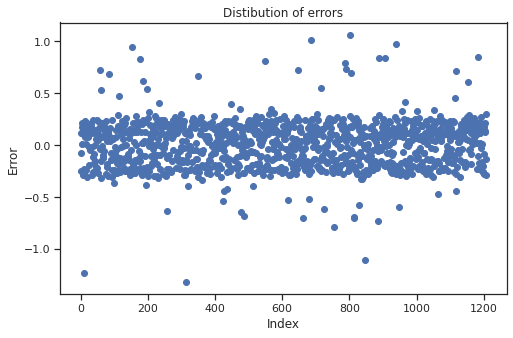

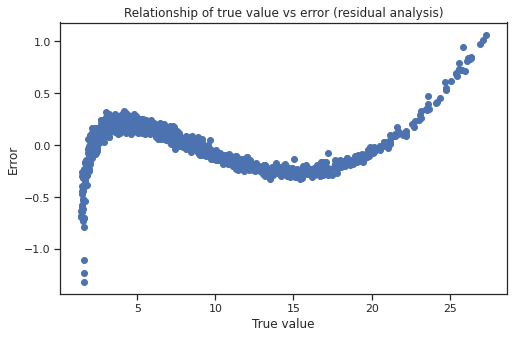

train_RMSE  train_R2  val_RMSE    val_R2
Model        0.23845  0.998605  0.223389  0.998616
Baseline     1.49545  0.959375  2.035660  0.926517

In [ ]:
X_train_best, y_train_best = remove_outliers(keep_high_correlated(X_train, y_train), y_train)
X_train_best, X_val_best, y_train_best, y_val_best = train_test_split(X_train_best, 
                                                              y_train_best, random_state=0, 
                                                              shuffle=True, test_size=0.2)

best_pipeline = clone(full_pipeline)
evaluate_model(X_train_best, X_val_best, y_train_best, y_val_best, best_pipeline)

Residual plots are still far away from perfect.
Some outliers are observed on the first graph.

On the second graph, we see some kind of cubic pattern. Fortunately, there is no heteroscedasticity and almost no outliers (at least they are not extreme).

Metrics look very good! RMSE much-much less than on the baseline. R2 is almost 1.
Both train, and validation show good numbers. They are equally good on train and val. --> no overfitting observed.

## Regularization and Parameters tuning
As we observe multicolinearity in our data, we should implement some regularization techniques.
In this section, we also are going to see feature importance.

In [ ]:
#plot_importance
def plot_importance(est, colnames, top_n=6):
    importance = pd.DataFrame({
        'abs_weight': np.abs(est.coef_),
        'feature': colnames
    })

    imp_top = importance.sort_values(by='abs_weight', ascending=False)[:top_n]

    plt.figure(figsize=(8, 5))
    sns.barplot(y='feature', x='abs_weight', data=imp_top, orient='h')

    plt.title(f'Top {top_n} important features')
    plt.show()

In [ ]:
#lasso + parameters tuning
cv = KFold(n_splits=5, shuffle=True, random_state=0)
lasso_pipeline = Pipeline([
    ('transform', pipeline),
    ('estimator', Lasso())
])
grid = {
    'estimator__alpha': [1.0, 0.1, 0.01, 0.001, 0.0001, 0]
}
lasso_gs = GridSearchCV(lasso_pipeline, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv)

In [ ]:
lasso_gs.fit(X_train_tr, y_train_tr)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        Pipeline(memory=None,
                                                 steps=[('impute',
                                                         KNNImputer(add_indicator=False,
                                                                    copy=True,
                                                                    metric='nan_euclidean',
                                                                    missing_values=-200,
                                                                    n_neighbors=3,
                                                                    weights='uniform')),
                                                        ('scale',
                                                         MinMaxScaler(copy=True,
          

In [ ]:
lasso_gs.best_params_

{'estimator__alpha': 0}

Well, it seems that it is better not to implement lasso regularization, as the best alpha = 0.
But still, let's use some small alpha o see hoe it affects the model.

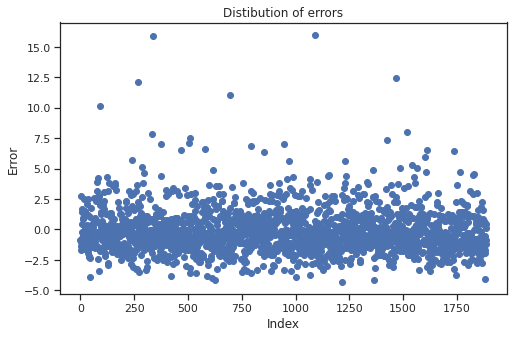

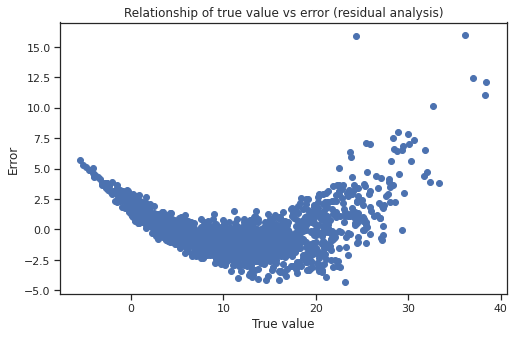

train_RMSE  train_R2  val_RMSE    val_R2
Model       1.898996  0.934491  1.860689  0.938607
Baseline    1.495450  0.959375  2.035660  0.926517

In [ ]:
lasso_pipeline = clone(lasso_pipeline)
lasso_pipeline.set_params(**{'estimator__alpha': 0.001})
evaluate_model(X_train_tr, X_val_tr, y_train_tr, y_val_tr, lasso_pipeline)

Outliers are observed on the first plot.

The residuals show quadratic pattern.This plot exhibit high heteroscedasticity.

RMSE is worse on the train for the model than for the baseline and gets better on the validation.

R2 score is a bit worse for the model compared to the baseline and stays remain on the validation.

* Lasso Model is apporximately the same as the baseline. It's not a surprise, because alpha parameter is really small. But it is more stable.

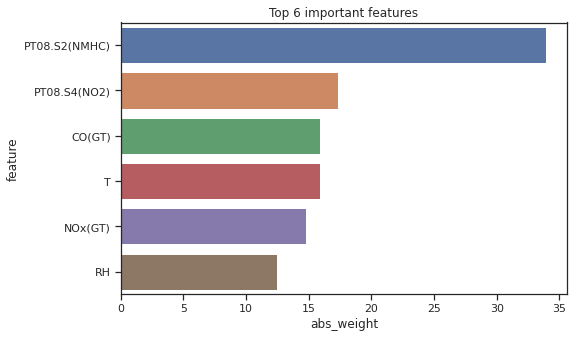

In [ ]:
plot_importance(lasso_pipeline.named_steps['estimator'], X_train.columns)

The majority of top 6 important features are the most correlated ones (coefficients from 0.85 to 0.98). It's interesting that temperature is on the second place despite the fact that the correlation coefficient is relatively low (0.42). Same is for relative humidity.

In [ ]:
#ridge + parameters tuning
ridge_pipeline = Pipeline([
    ('transform', pipeline),
    ('estimator', Ridge())
])

ridge_gs = GridSearchCV(ridge_pipeline, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv)

In [ ]:
ridge_gs.fit(X_train_tr, y_train_tr)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        Pipeline(memory=None,
                                                 steps=[('impute',
                                                         KNNImputer(add_indicator=False,
                                                                    copy=True,
                                                                    metric='nan_euclidean',
                                                                    missing_values=-200,
                                                                    n_neighbors=3,
                                                                    weights='uniform')),
                                                        ('scale',
                                                         MinMaxScaler(copy=True,
          

In [ ]:
ridge_gs.best_params_

{'estimator__alpha': 0.01}

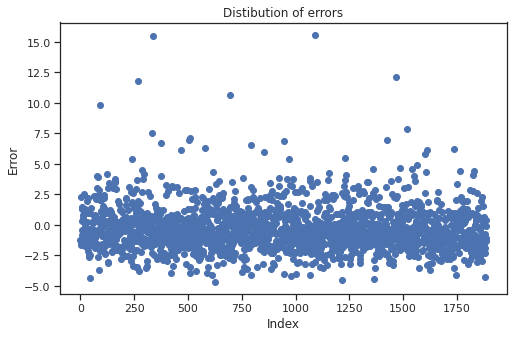

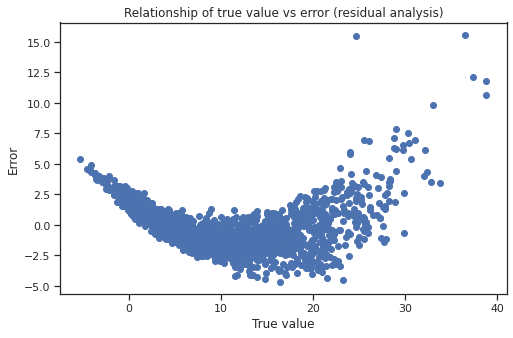

train_RMSE  train_R2  val_RMSE    val_R2
Model        1.89308  0.934898  1.879733  0.937343
Baseline     1.49545  0.959375  2.035660  0.926517

In [ ]:
ridge_pipeline = clone(ridge_pipeline)
ridge_pipeline.set_params(**ridge_gs.best_params_)
evaluate_model(X_train_tr, X_val_tr, y_train_tr, y_val_tr, ridge_pipeline)

Outliers are observed on both the first and the sencond plots.

The residuals show quadratic pattern.This plot exhibit high heteroscedasticity.

RMSE is worse on the train for the model than for the baseline. It gets a bit worse on the validation, but the deterioration is not as critical as on the baseline.

R2 score is a bit worse for the model compared to the baseline and stays remain on the validation.

* Ridge Model shows more stable results compared to baseline.

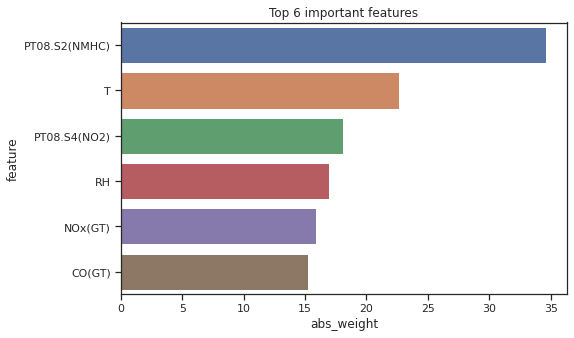

In [ ]:
plot_importance(ridge_pipeline.named_steps['estimator'], X_train.columns)

Feature importance is the same as for lasso regression.

## Polynomial regression
After all these observations, one got clear: our data cannot be described by linear model well. I think, the polynomial will fit much better. The best suited degree of the polynomial will be discovered with the GridSearch.

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [ ]:
param_grid = {'polynomialfeatures__degree': np.arange(5)}

poly_gs = GridSearchCV(PolynomialRegression(), param_grid, 
                       n_jobs=-1, 
                       scoring=['neg_mean_squared_error', 'r2'], 
                       refit='neg_mean_squared_error', 
                       cv=cv) 

In [ ]:
poly_gs.fit(X_train_tr, y_train_tr)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'polynomialfeatures__degree

In [ ]:
poly_gs.best_params_

{'polynomialfeatures__degree': 3}

In [ ]:
poly_pipeline = Pipeline([
    ('transform', pipeline),
    ('estimator', PolynomialRegression())
])

best_params = {'estimator__polynomialfeatures__degree': poly_gs.best_params_['polynomialfeatures__degree']}
poly_pipeline.set_params(**best_params)

Pipeline(memory=None,
         steps=[('transform',
                 Pipeline(memory=None,
                          steps=[('impute',
                                  KNNImputer(add_indicator=False, copy=True,
                                             metric='nan_euclidean',
                                             missing_values=-200, n_neighbors=3,
                                             weights='uniform')),
                                 ('scale',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('transform',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<ufunc 'log1p'>,
                                                      inv_kw_args=None,
                                                      in

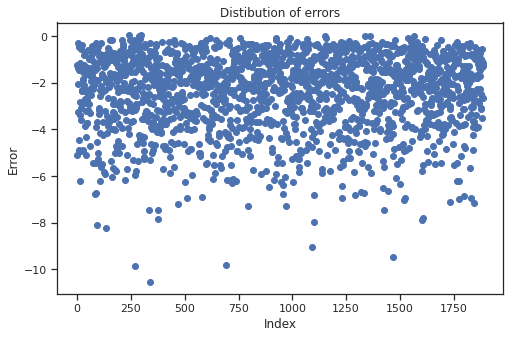

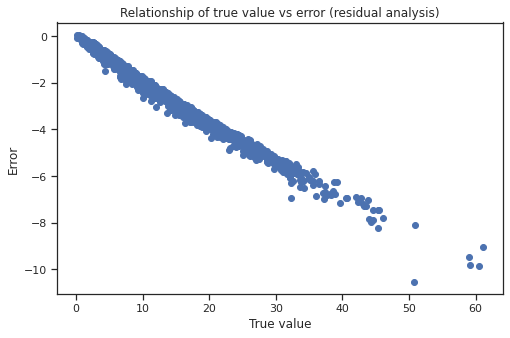

train_RMSE  train_R2  val_RMSE    val_R2
Model       0.043066  0.999966   2.90840  0.850003
Baseline    1.495450  0.959375   2.03566  0.926517

In [ ]:
evaluate_model(X_train_tr, X_val_tr, y_train_tr, y_val_tr, poly_pipeline)

Well, the first graph looks more appropriate than previous one, but still there are outliers, even if they are not so extreme.
Same could be said about the second graph. There is no more quadratic or cubic pattern. Now, it is a line with some outliers on the right. At the same time, we escape heteroscedasticity.

Scores on the train look fantastic, but then bad news come on the validation: our model is very-very overfitted. RMSE soared to the skies. R2 doesn't feel good either.

Interesting to see, how it will look like after implementing 2 degree of polynom.

In [ ]:
poly2_pipeline = Pipeline([
    ('transform', pipeline),
    ('estimator', PolynomialRegression())
])

best_params = {'estimator__polynomialfeatures__degree':2}
poly2_pipeline.set_params(**best_params)

Pipeline(memory=None,
         steps=[('transform',
                 Pipeline(memory=None,
                          steps=[('impute',
                                  KNNImputer(add_indicator=False, copy=True,
                                             metric='nan_euclidean',
                                             missing_values=-200, n_neighbors=3,
                                             weights='uniform')),
                                 ('scale',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('transform',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<ufunc 'log1p'>,
                                                      inv_kw_args=None,
                                                      in

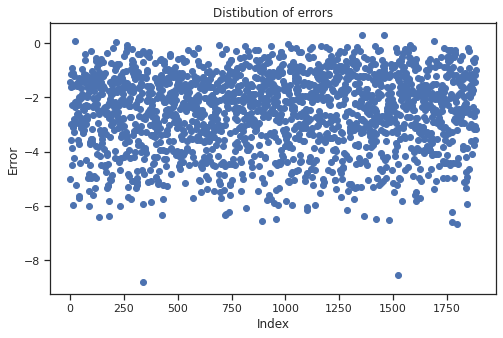

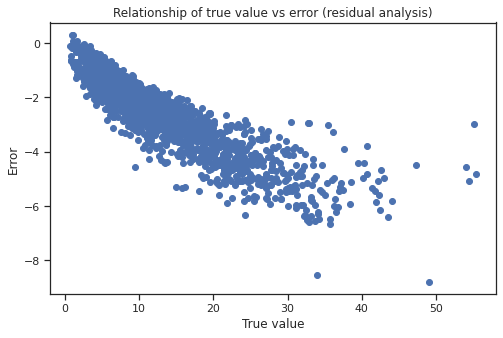

train_RMSE  train_R2  val_RMSE    val_R2
Model       0.293487  0.998435  2.910729  0.849763
Baseline    1.495450  0.959375  2.035660  0.926517

In [ ]:
evaluate_model(X_train_tr, X_val_tr, y_train_tr, y_val_tr, poly2_pipeline)

Overfitting... again...

Heteroscedasticity... again...

Outliers... again...

# Conclusions:
On this notebook we:
1. did some exploratory analysis: vizualised and researched feature and target distributions, outliers, correlations, some statistics in .describe() and missing values.
2. created new features and saw, that differences in their ditributions are statistically significant.
3. Then, we modified our data: deleted or impured Nans, scaled and logged our data.
4. We constracted the baseline
5. We did some more changes (outliers removal, log target, keep high correlated features, dimension reduction) and saw, how they affect model and, namely, rmse, r2 scores and residuals. Some techniques improved the model, some -- sisn't. As a result, combined dest techniques.
6. Implemented regularization
7. Implemented polynomial features with degree 2 and 3.
8. Saw features importance.

As a result, implemeted best techniques we got rmse = 0.223389 and r2 = 0.998616 on validation (which are very good results). This model show stable results. 

However, because of resudual plots, it seems to me that linear regression doesn't fit our data properly. Maybe, it makes sense to try some other models (e.g. KNN).

P.s. my cats wish you good day and sunny mood :)

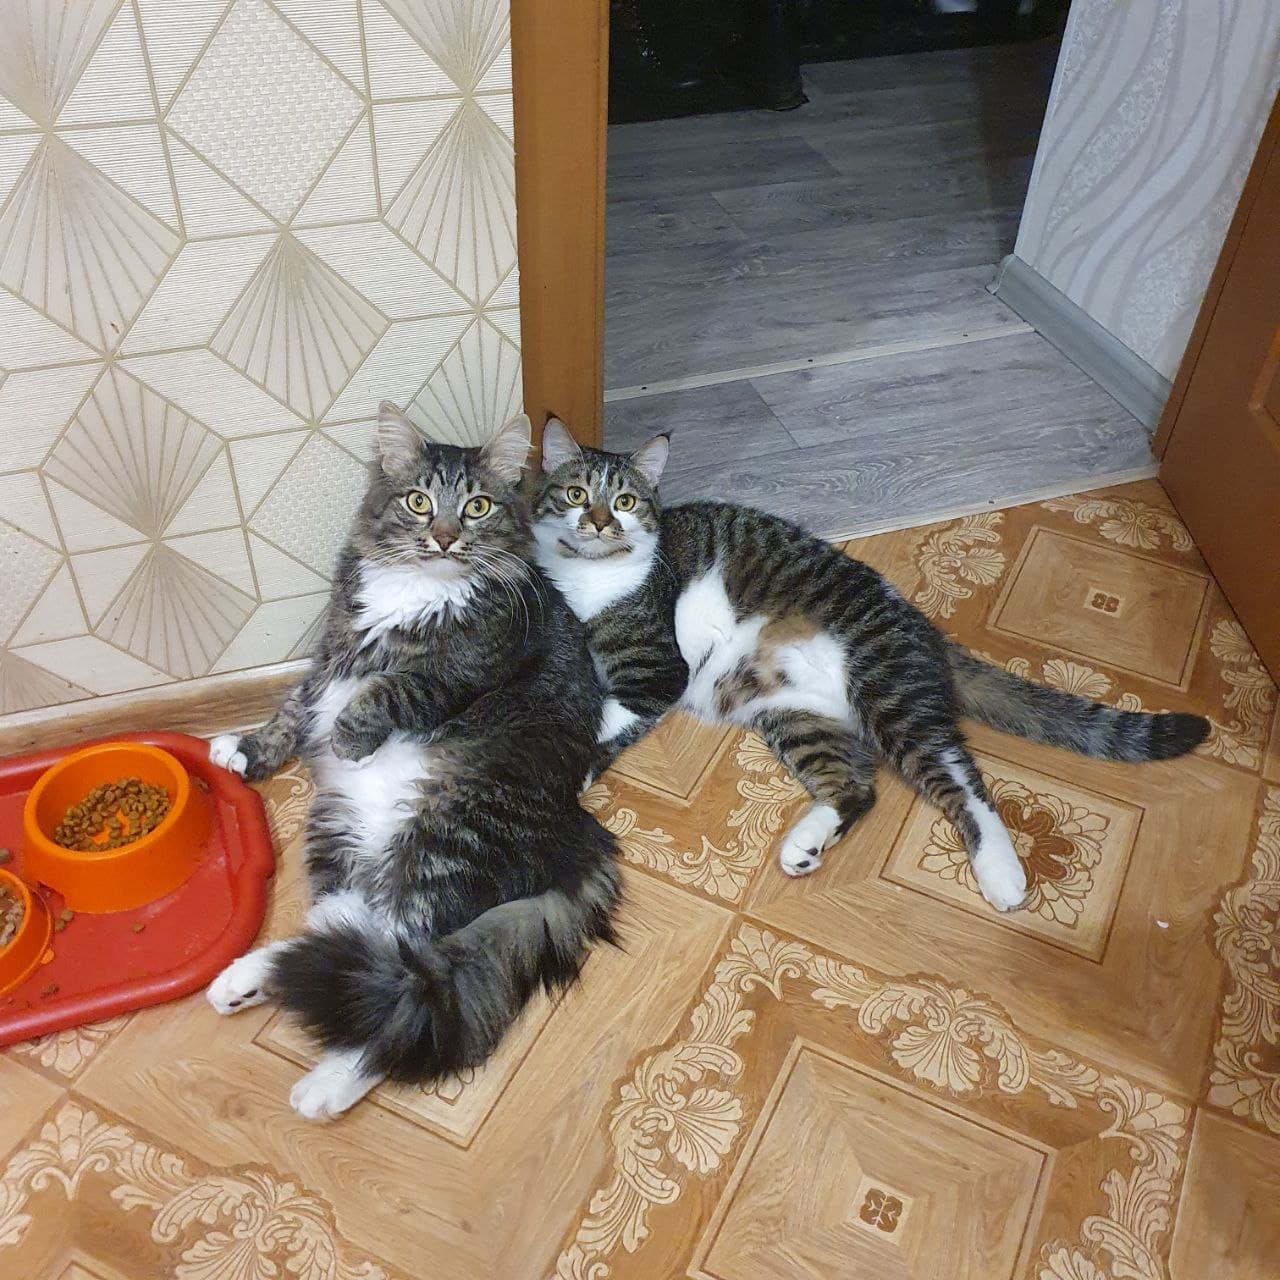